### Dealing with Detection & Segmentation

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [5]:
#@save
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

#@save
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)
    
#@save
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    
    return train_iter, val_iter

batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

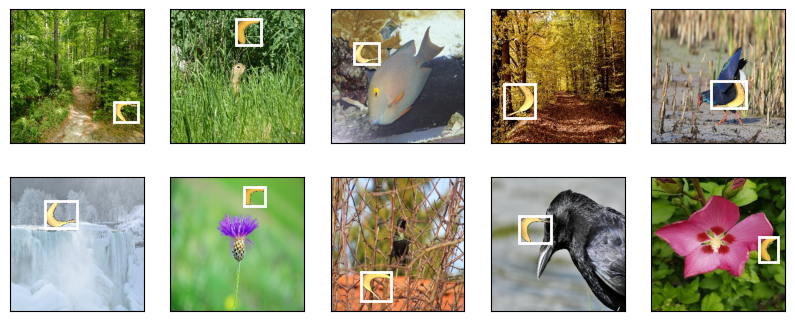

In [6]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

In [6]:
ci_cd_summary = "Our project employs a decent CI/CD pipeline leveraging GitHub Actions and Google Cloud Build to streamline testing, linting, and deployment. The core CI workflow automatically runs unit tests using pytest and code linting with ruff on every commit or pull request. This helps maintain code quality and consistency while catching issues early, we have around 14 tests covering everything from data to training. We test across multiple operating systems (Ubuntu, macOS) and Python versions to ensure cross-platform compatibility. To speed up build times, pip caching is used for Python dependencies in the github workflows though locally & in cloud we are using uv to speed up the dependency resolution process. Although DVC is integrated into the pipeline to track data and model file changes (e.g., data.dvc, models.dvc), we found it unnecessary in our case, as the dataset remained static throughout development, but we used DVC extensively to build docker containers on cloud if there is change in model weights and biases. For deployments, we use with Google Cloud Build, which automatically builds Docker images when data updates or new commits land on the main branch. These images are deployed to Cloud Run, eliminating the need for time-consuming local builds and ensuring production readiness."
len(ci_cd_summary.split())

203

### Detection and Segmentation

We are going to implement a simple architecture for classification + regression heads. 

In [ ]:
import torch.nn as nn

class Localisation(nn.Module): 
    def __init__(self): 
        self.featureExtractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # considering we have 10 classes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )
        
        # 4 coordinates for bounding box
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4) # 10 * 4 
        )  
        
        self.cnnClassifier = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 10, kernel_size=1, stride=1)
        )
        
        self.cnnRegressor = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 4, kernel_size=1, stride=1) # 10 * 4
        )
    
    def forward(self, x):
        features = self.featureExtractor(x)
        class_output = self.classifier(features) # class_output = self.cnnClassifier(features)
        bbox_output = self.regressor(features) # bbox_output = self.cnnRegressor(features)
        return class_output, bbox_output
    
    def loss(self, class_output, bbox_output, labels):
        class_loss = nn.CrossEntropyLoss()(class_output, labels[:, 0].long())
        bbox_loss = nn.MSELoss()(bbox_output, labels[:, 1:5])
        return class_loss + bbox_loss
    


Next steps : FC are a bottle neck for performance we are going to use conv layers instead and use the channel space and run this on multiple scales. Typically we are going to slide a window over the image and extract features for the same and do our predictions for the same and using mulitple windows and classification scores we are going to use non maximal suppression to pick the best box. 